# Colates, cleans and analyses soil heat flux data from Rain shelter barley trail

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import lmfit as fitter
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates

In [2]:
Data = pd.read_pickle('.\DataFrames\TempAndRadnCleaned.pkl')
Data = Data.loc[:'2015-02-24']
SoilTempData = pd.read_pickle('.\DataFrames\SoilTemp.pkl')
SoilWaterData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
Data.columns = Data.columns.droplevel(level=[3,4,5,6,7])
Data.sort_index(axis=1, inplace = True)
SoilTempData.sort_index(axis=1, inplace = True)
SoilWaterData.sort_index(axis=1, inplace = True)
Data.sort_index(inplace = True)
SoilTempData.sort_index(inplace = True)
SoilWaterData.sort_index(inplace = True)
Data = Data.resample('15T').mean()

In [3]:
Cultivars = ['Dash','Omaka']
Irrigations = ['High','Low','Mid']
IrrigationsShort = ['High','Low']
BD = 1.1
CW = 4179 # specific heat capacity of water (J/kg/oK)
CD = 840 # specific heat capacity of dry soil (J/kg/oK)
Cs = BD * CD # heat capaacity of dry soil

Styles = ['b--','b--','b--','b--','r--','r--','r--','r--','g--','g--','g--','g--',
          'b-','b-','b-','b-','r-','r-','r-','r-','g-','g-','g-','g-']

Styles2 = ['b--','b--','b--','r--','r--','r--',
          'b-','b-','b-','r-','r-','r-']

# Have a look at the heat flux plate data 

Text(0,0.5,'HeatFlux (W/m2)')

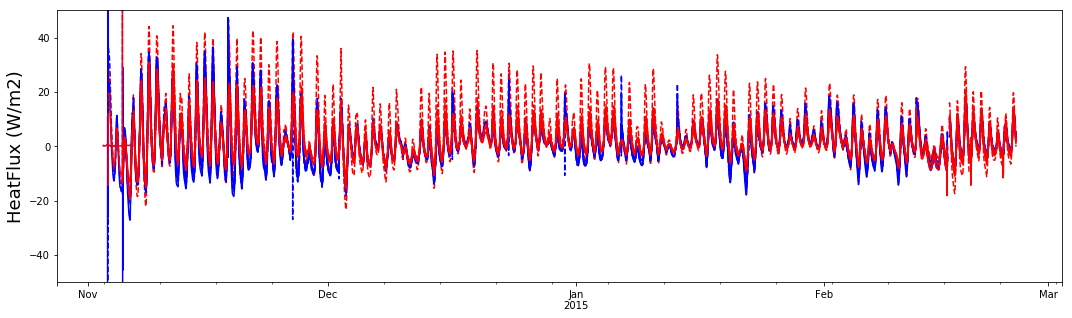

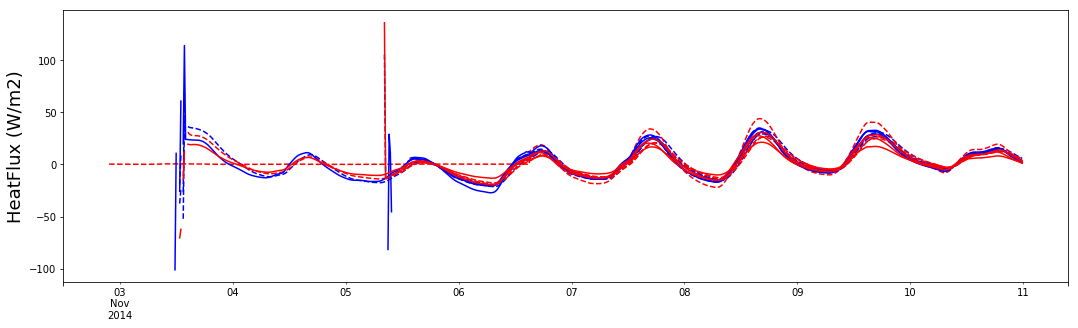

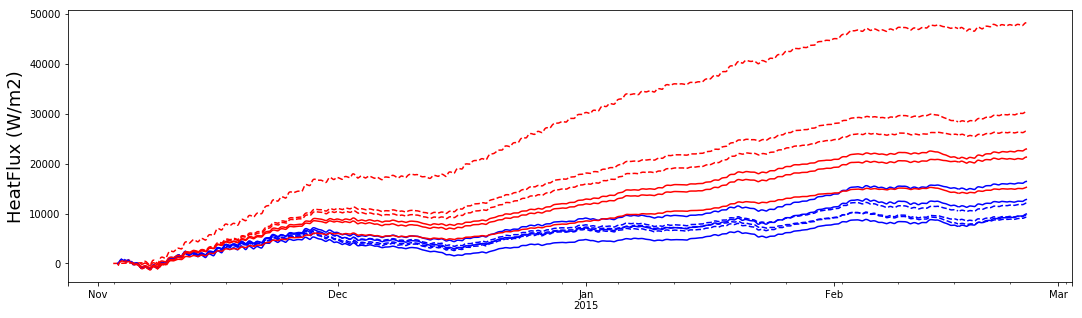

In [4]:
Data.HeatFlux.plot(figsize=(18,5), style = Styles2, legend = False)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)
plt.ylim(-50,50)
Data.HeatFlux.loc['2014-10-1':'2014-11-10'].plot(figsize=(18,5), style = Styles2, legend = False)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)
Data.HeatFlux.cumsum().plot(figsize=(18,5), style = Styles2, legend = False)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)

# There appears to be positive heat flux into the soil and treatment differences 

# Now lets have a look at the soil temperature above the heat flux plates

Text(0,0.5,'Temperature (oC)')

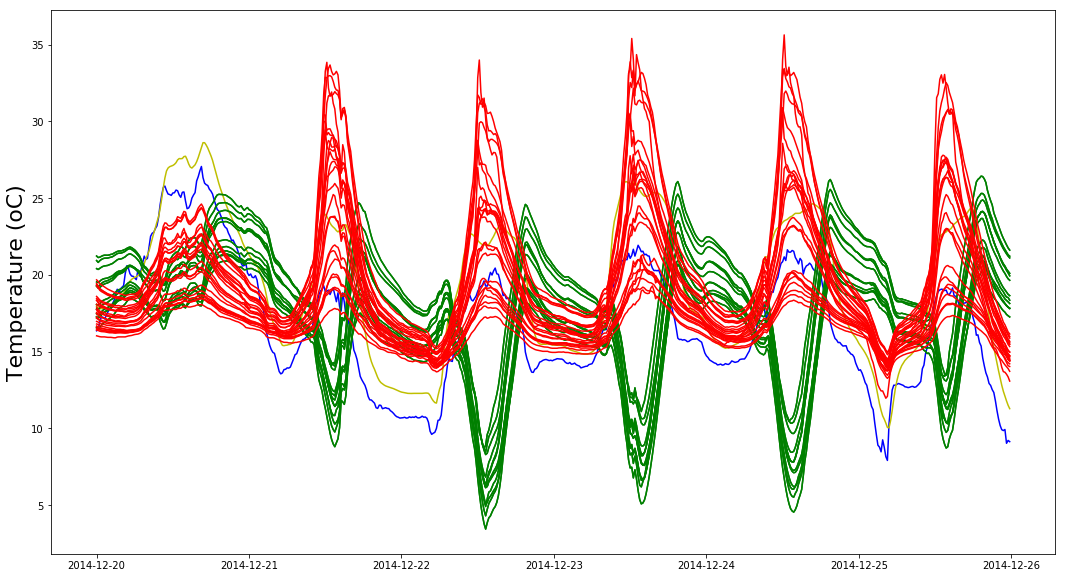

In [5]:
Start = '2014-12-20'
End ='2014-12-25'
figure = plt.figure(figsize=(18,10))
plt.plot(Data.AirTemperature.loc[Start:End], color = 'b')
plt.plot(Data.PannelTemperature.loc[Start:End], color = 'y')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SurfaceSoilTemp.loc[Start:End], color = 'r')
plt.ylabel('Temperature (oC)',fontsize=22)
#plt.plot(TopTempDF.loc[Start:End], color = 'k')

# Averaging thermocouple data is shit.  Use temp from cs650 instead

# Get the soil temperatue data for the top 15cm 

Text(0,0.5,'Temperature (oC)')

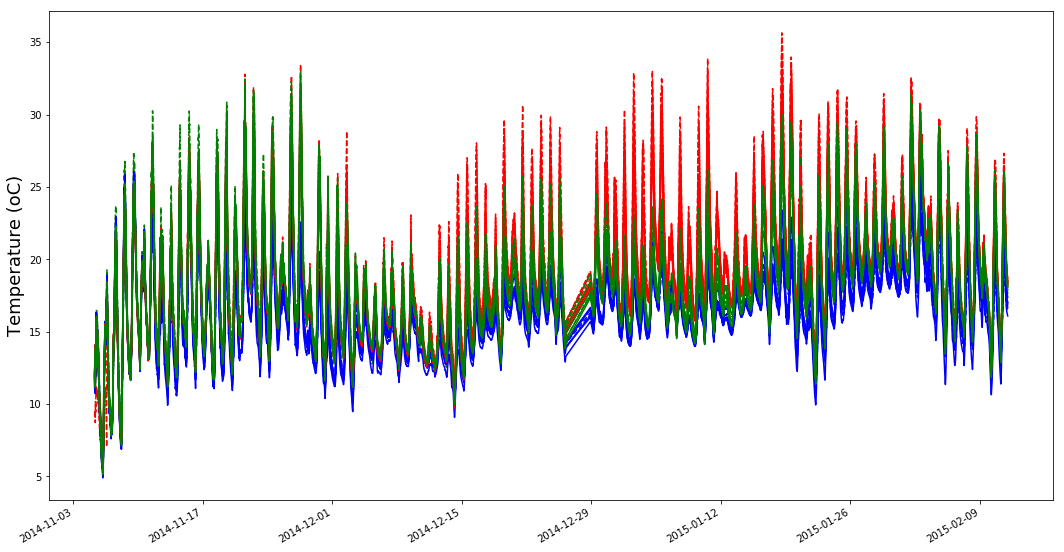

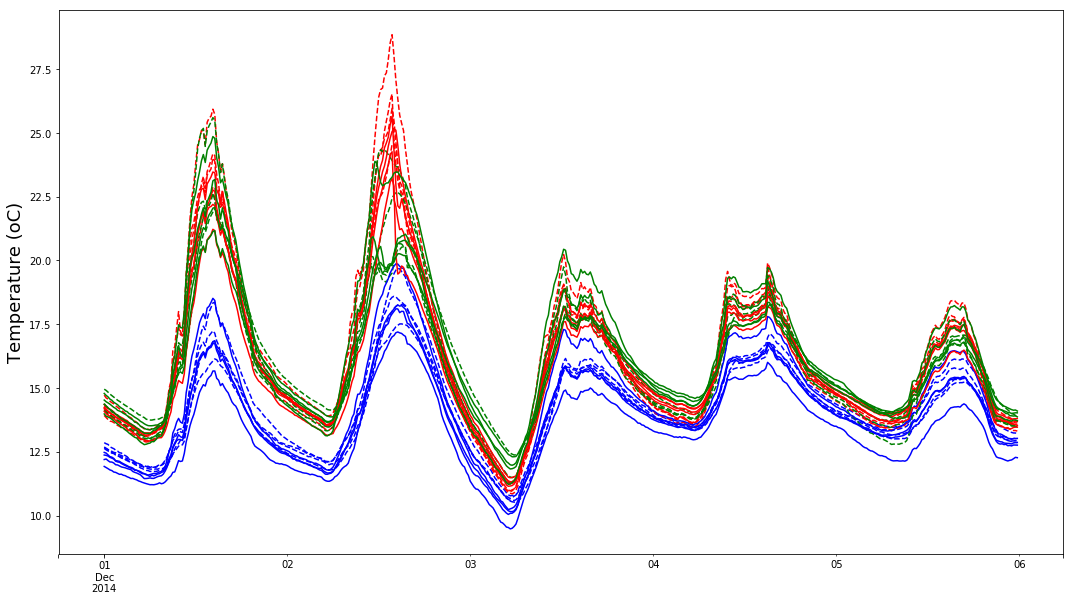

In [6]:
TopTemp = np.add(SoilTempData.loc[:'2015-02-11','D1B'].values,SoilTempData.loc[:'2015-02-11','D1I'].values)
TopTemp /= 2
TopTemp = np.add(TopTemp,SoilTempData.loc[:'2015-02-11','D2'].values)
TopTemp /= 2

tup = ['TopTemp']
reps = [1,2,3,4]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,reps],names=['Measurement','Cultivar','Irrigation',''])
#NewIndex = NewIndex.droplevel(3)
TopTempDF = pd.DataFrame(data = TopTemp, index = SoilTempData.loc[:'2015-02-11',:].index, columns = NewIndex)

TopTempDF.plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Temperature (oC)',fontsize=18)
TopTempDF.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Temperature (oC)',fontsize=18)

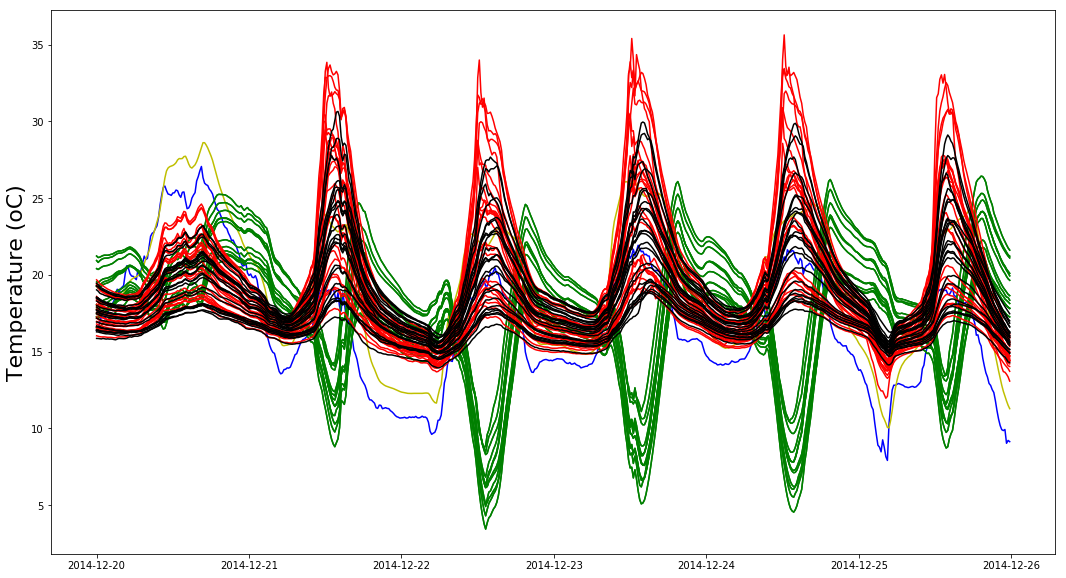

In [7]:
Start = '2014-12-20'
End ='2014-12-25'
figure = plt.figure(figsize=(18,10))
plt.plot(Data.AirTemperature.loc[Start:End], color = 'b')
plt.plot(Data.PannelTemperature.loc[Start:End], color = 'y')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SurfaceSoilTemp.loc[Start:End], color = 'r')
plt.ylabel('Temperature (oC)',fontsize=22)
plt.plot(TopTempDF.loc[Start:End], color = 'k')

# The CS650 data is better so use that.

# Bring in the soil water data for the top layer

Text(0,0.5,'Volumetric Water Content (mm/mm)')

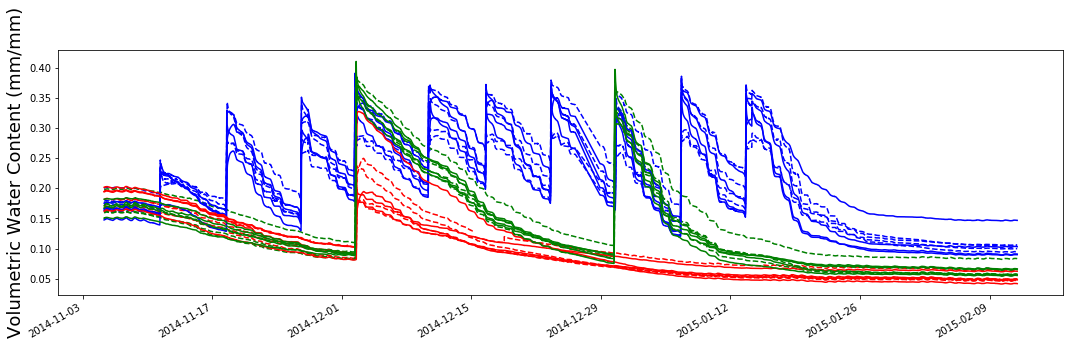

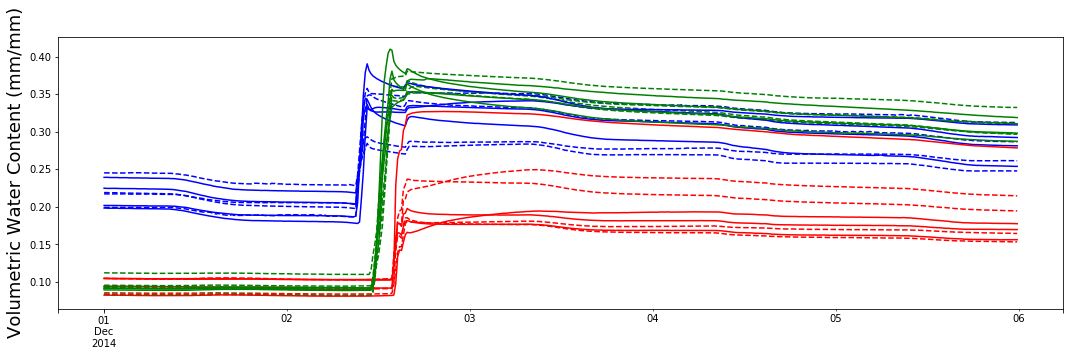

In [8]:
TopWater = np.add(SoilWaterData.loc[:'2015-02-11','D1B'].values,SoilWaterData.loc[:'2015-02-11','D1I'].values)
TopWater /=2
TopWater *= 1/BD

tup = ['TopWater']
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,reps],names=['Measurement','Cultivar','Irrigation',''])
#NewIndex = NewIndex.droplevel(3)
TopWaterDF = pd.DataFrame(data = TopWater, index = SoilWaterData.loc[:'2015-02-11'].index, columns = NewIndex)

TopWaterDF.plot(figsize=(18,5),style=Styles, legend=False)
plt.ylabel('Volumetric Water Content (mm/mm)',fontsize=18)
TopWaterDF.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,5),style=Styles, legend=False)
plt.ylabel('Volumetric Water Content (mm/mm)',fontsize=18)

# Calculate the specific heat capacity of soils

Text(0,0.5,'Soil Heat capacity (J/oc/kg)')

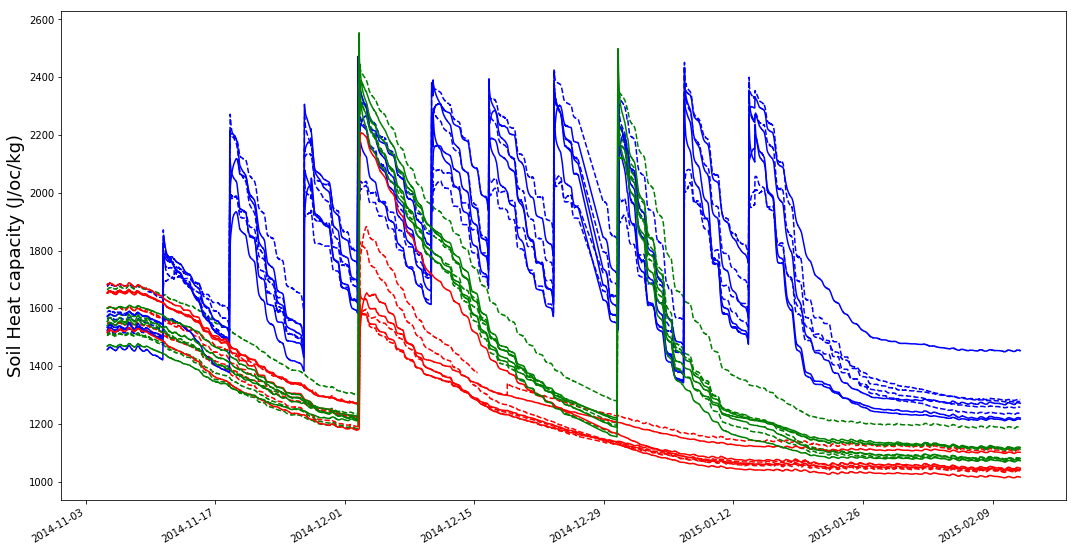

In [9]:
Cw = np.multiply(TopWater,CW)
Cs = np.add(Cw,CD)

tup = ['Cs']
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,[1,2,3,4]],names=['Measurement','Cultivar','Irrigation',''])
NewIndex = NewIndex.droplevel(3)
CsDF = pd.DataFrame(data = Cs, index = SoilWaterData.index, columns = NewIndex)

CsDF.plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Soil Heat capacity (J/oc/kg)',fontsize=18)

## Calculate temperature deltas

Text(0,0.5,'Temperature Delta(oC)')

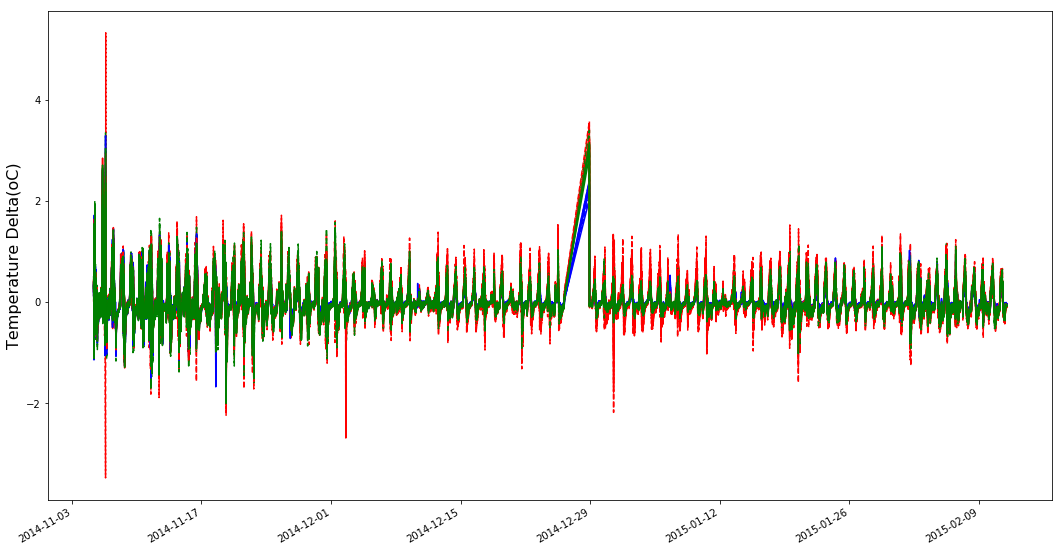

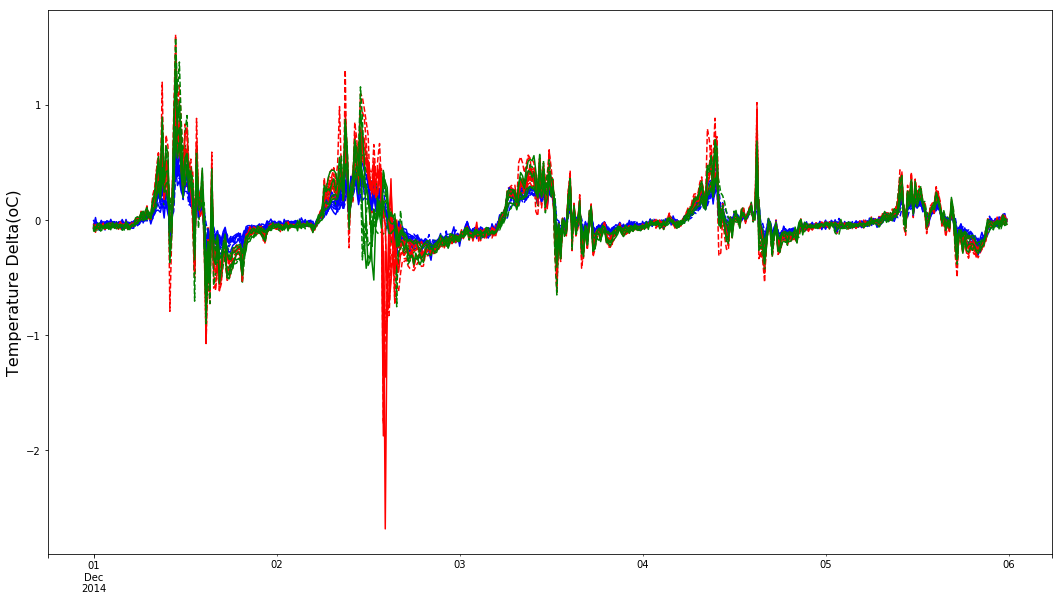

In [10]:
DeltaTemp = TopTempDF.diff()
DeltaTemp.plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Temperature Delta(oC)',fontsize=16)
DeltaTemp.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,10),style=Styles, legend=False)
plt.ylabel('Temperature Delta(oC)',fontsize=16)

# Calculate energy stored in soil above heat flux plates

Text(0,0.5,'Top Layer Energy storage (MJ)')

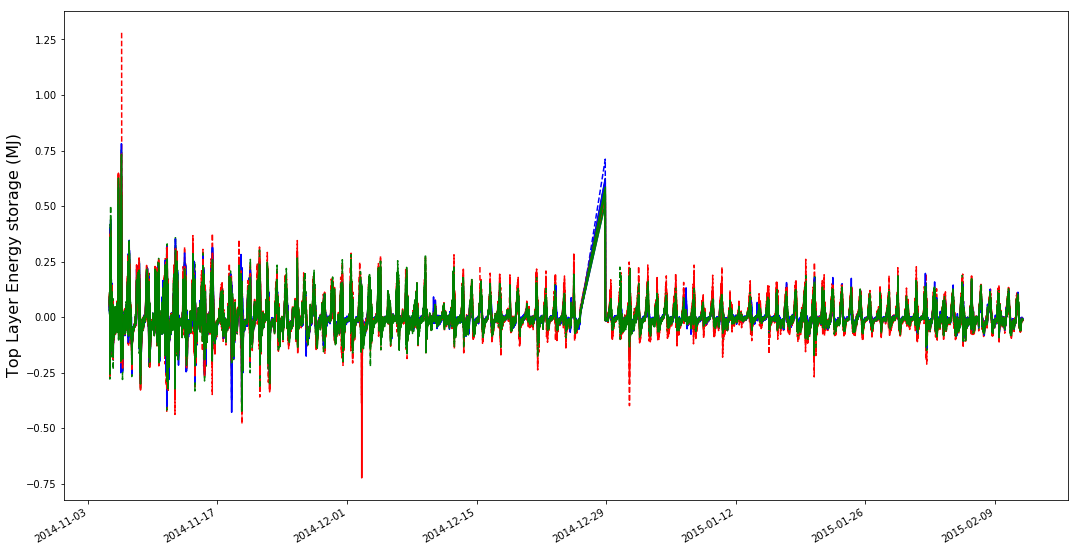

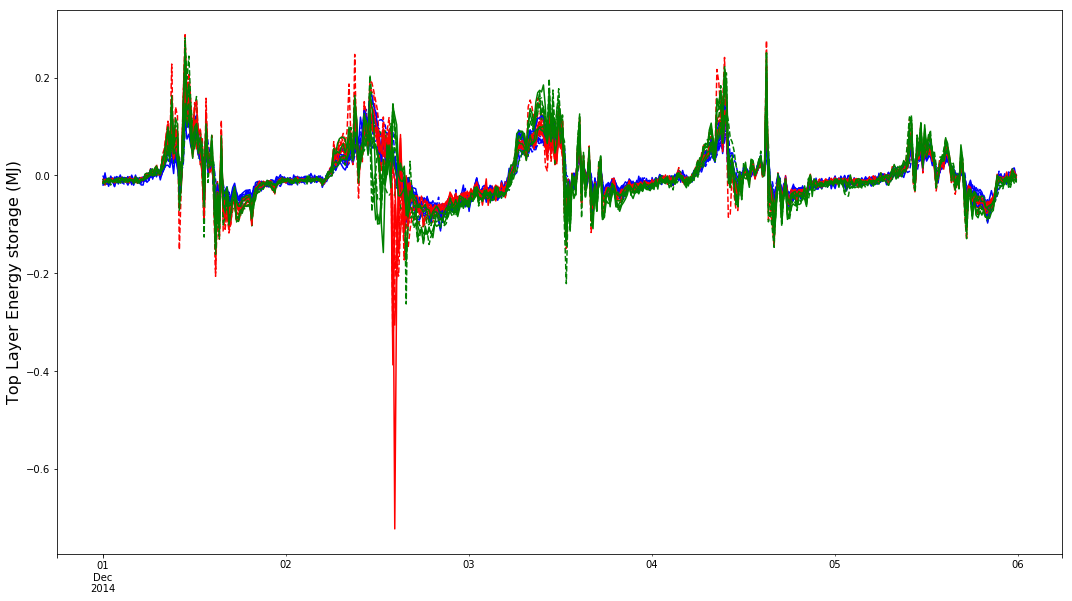

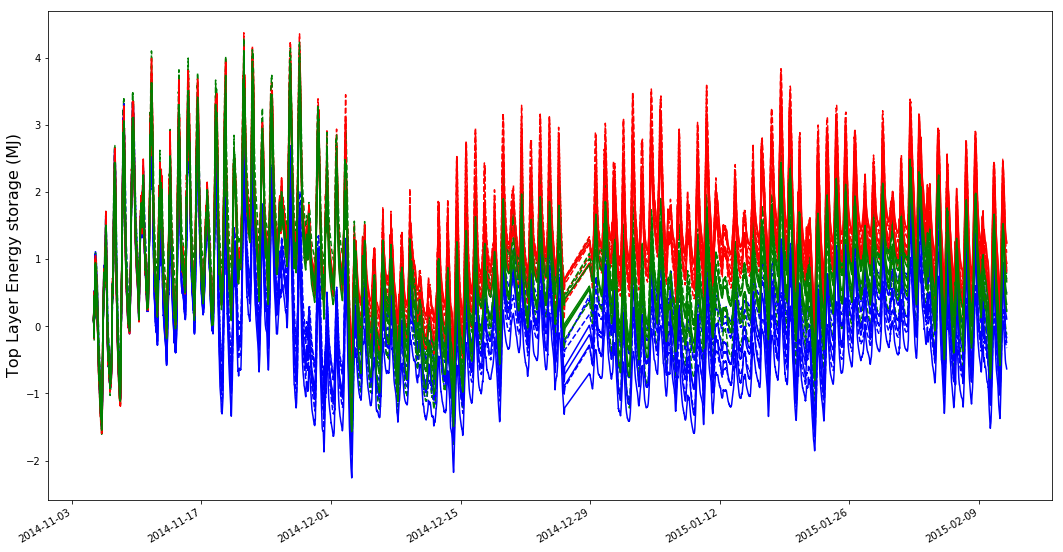

In [11]:
#Calculate the joules of energy stored in the soil per kg of soil
EnergyStored = np.multiply(DeltaTemp.values, CsDF.values) 
#Adjust for soil depth to give joules in the top 150 mm
EnergyStored = np.multiply(EnergyStored,150)
#Convert to MJ
EnergyStored = np.divide(EnergyStored,1000000)

tup = ['S']
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,[1,2,3,4]],names=['Measurement','Cultivar','Irrigation',''])
TopEnergy = pd.DataFrame(data = EnergyStored, index = SoilWaterData.index, columns = NewIndex)

TopEnergy.plot(figsize=(18,10),style=Styles, legend=False)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=16)
TopEnergy.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,10),style=Styles,legend=False)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=16)
TopEnergy.cumsum().plot(figsize=(18,10),style=Styles, legend=False)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=16)

### subset of plots where heat flux was measured

In [12]:
SoilHeat = TopEnergy.loc[:,[('S','Dash','High',1),('S','Dash','High',3),('S','Dash','High',4),
          ('S','Dash','Low',1),('S','Dash','Low',3),('S','Dash','Low',4),
          ('S','Omaka','High',1),('S','Omaka','High',3),('S','Omaka','High',4),
          ('S','Omaka','Low',1),('S','Omaka','Low',2),('S','Omaka','Low',4),]]

SoilHeat.columns = SoilHeat.columns.droplevel(3)

#Index dates when soil temp was measured
DateIndex = SoilHeat.index.tolist()

# Convert instantatious heat flux to Accumulated energy (W - MJ)

Text(0,0.5,'Deep Soil Heat Flux (MJ)')

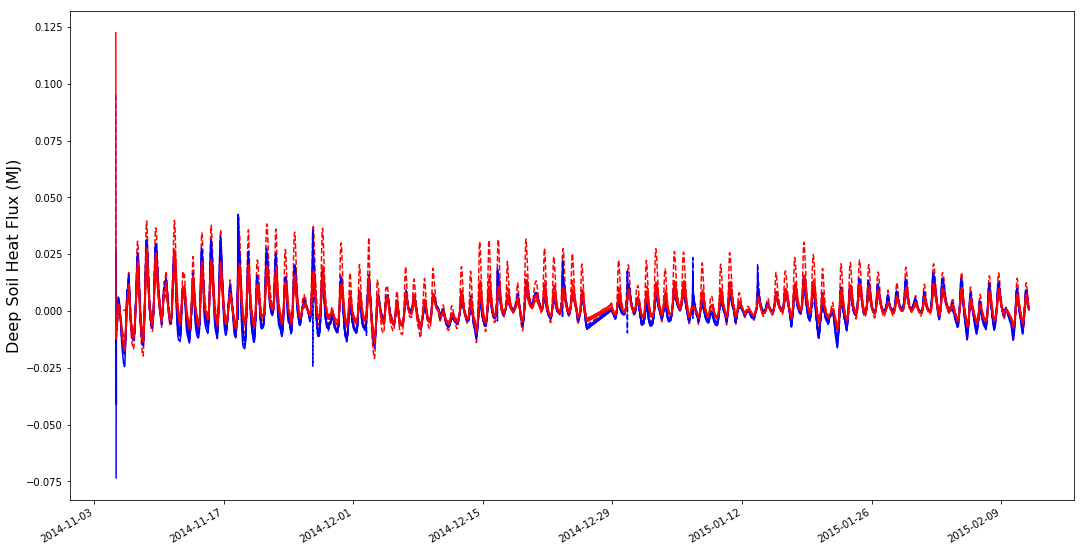

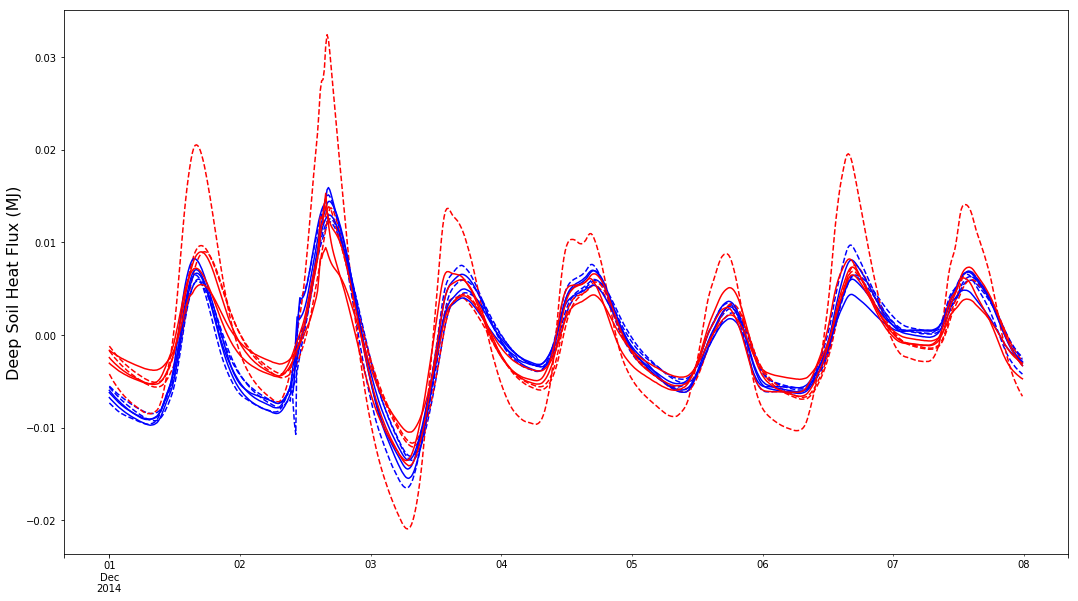

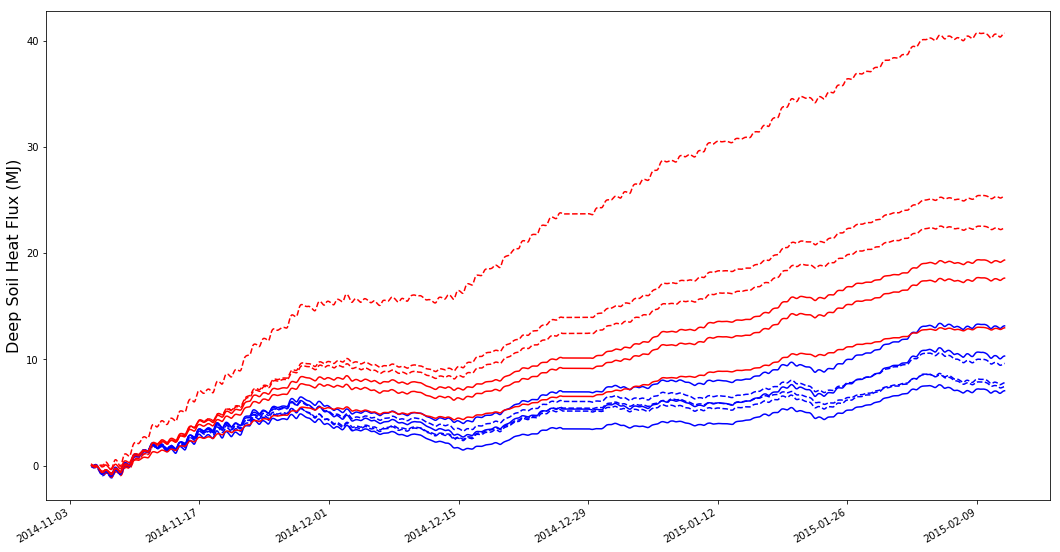

In [13]:
#Multiply by the duration of the measurement period to go from W/m2 to J/m2
HeatFluxMJ = np.multiply(Data.HeatFlux.loc[DateIndex,:].values,900)
#divide by a million to conver to JM
HeatFluxMJ = np.divide(HeatFluxMJ,1000000)

tup = ['HeatFluxMJ']
Irrigs = ['High','Low']
reps = [1,2,3]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigs,reps],names=['Measurement','Cultivar','Irrigation',''])
NewIndex = NewIndex.droplevel(3)
HeatFluxDF = pd.DataFrame(data = HeatFluxMJ, index = Data.loc[DateIndex,:].index, columns = NewIndex)

HeatFluxDF.plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=16)
HeatFluxDF.loc['2014-12-1':'2014-12-7'].plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=16)
HeatFluxDF.cumsum().plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=16)

# Add the two heat fluxes together to give total heat flux to the soil

In [14]:
DaylightIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or 

Text(0,0.5,'Soil Heat Flux (W/m2)')

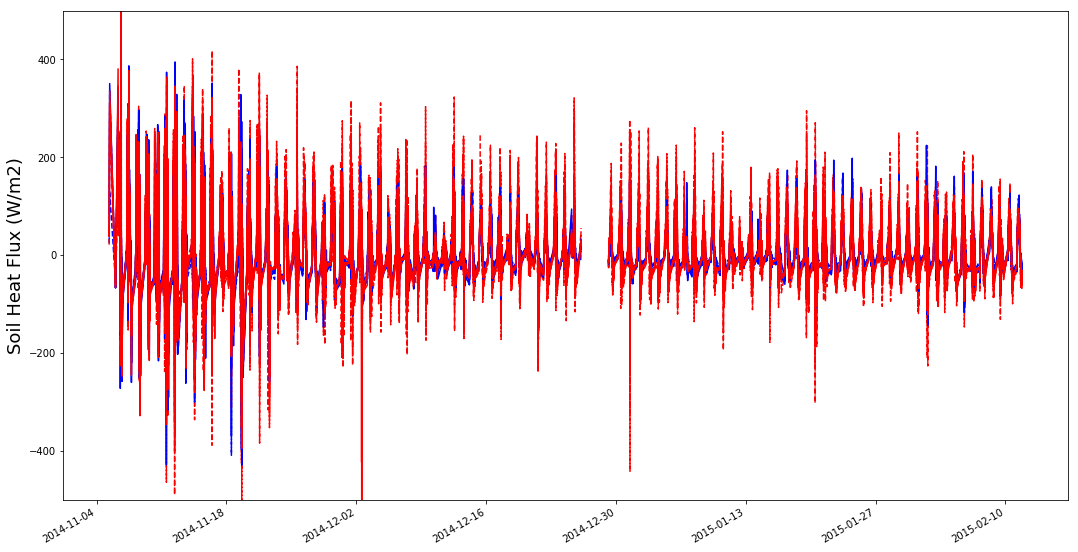

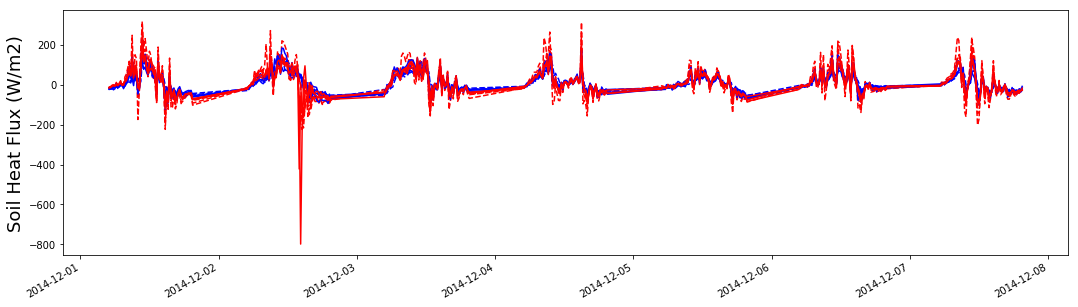

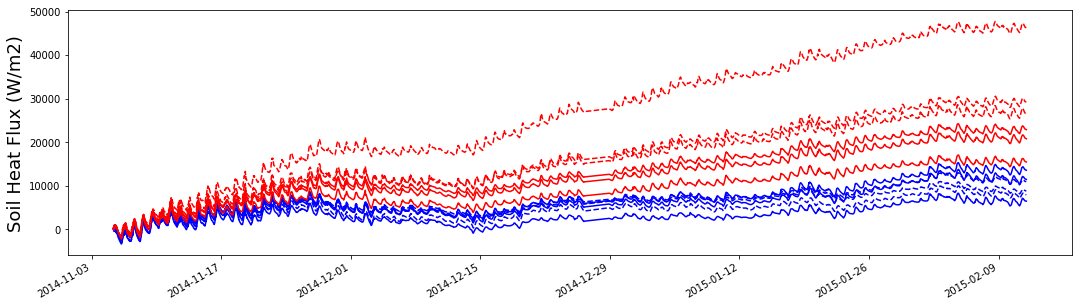

In [15]:
#Add total energy fluxes together
SoilHeatFluxMJ = np.add(HeatFluxDF.values,SoilHeat.values)
#Divide by the duration of the measurement period to make instanious (MJ/m2 to MW/m2)
SoilHeatFluxMW = np.divide(SoilHeatFluxMJ,900)
#Multiply by a million to go from MW/m2 to W/m2
SoilHeatFluxW = np.multiply(SoilHeatFluxMW,1000000)

IndexTups =  [('SoilHeat','Dash','High','1'),('SoilHeat','Dash','High','3'),('SoilHeat','Dash','High','4'),
          ('SoilHeat','Dash','Low','1'),('SoilHeat','Dash','Low','3'),('SoilHeat','Dash','Low','4'),
          ('SoilHeat','Omaka','High','1'),('SoilHeat','Omaka','High','3'),('SoilHeat','Omaka','High','4'),
          ('SoilHeat','Omaka','Low','1'),('SoilHeat','Omaka','Low','2'),('SoilHeat','Omaka','Low','4')]
NewIndex = pd.MultiIndex.from_tuples(IndexTups,names=['Var','Cultivar','Irrigation','Block'])
SoilHeatFluxMJ = pd.DataFrame(data = SoilHeatFluxMJ, index = Data.ix[DateIndex,:].index, columns = NewIndex)
SoilHeatFluxW = pd.DataFrame(data = SoilHeatFluxW, index = Data.ix[DateIndex,:].index, columns = NewIndex)

SoilHeatFluxW.ix[DaylightIndex,:].plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Soil Heat Flux (W/m2)', fontsize = 18)
plt.ylim(-500,500)
SoilHeatFluxW.ix[DaylightIndex,:].ix['2014-12-1':'2014-12-7'].plot(figsize=(18,5),style=Styles2, legend=False)
plt.ylabel('Soil Heat Flux (W/m2)', fontsize = 18)
SoilHeatFluxW.cumsum().plot(figsize=(18,5),style=Styles2, legend=False)
plt.ylabel('Soil Heat Flux (W/m2)', fontsize = 18)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


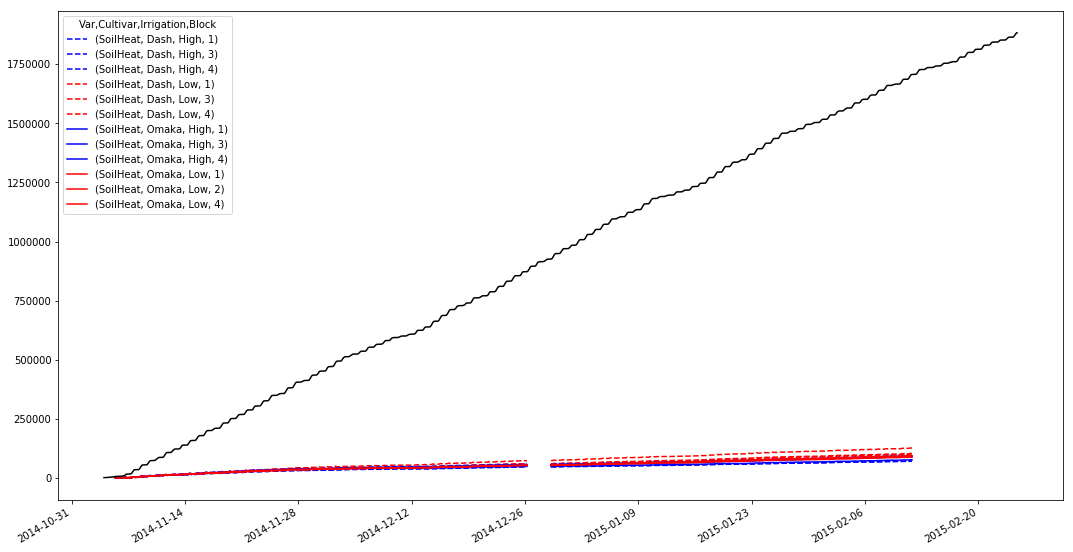

In [16]:
Styles = ['b--','b--','b--','r--','r--','r--',
          'b-','b-','b-','r-','r-','r-']
SoilHeatFluxW.loc[DaylightIndex,:].cumsum().plot(figsize=(18,10),style=Styles)
#Plot incoming net radiation (taking total radiation, converting to W and multiplying by 0.66 to give net radn)
plt.plot(Data.IncomingRadnKW.loc[DaylightIndex].index,Data.IncomingRadnKW.loc[DaylightIndex].multiply(1000*0.66).cumsum(),'-',color='k',label='Incomming Radn')

# Relative to incoming energy, Soil heat flux is quite small over the duration of the experiment

In [17]:
SoilHeatFluxW.columns = SoilHeatFluxW.columns.droplevel('Var')

In [18]:
SoilHeatFluxW.index.name = 'Date'
SoilHeatFluxWLong = SoilHeatFluxW.resample('h').mean().unstack()
SoilHeatFluxWLong.name = 'G'
SoilHeatFluxWLong.to_pickle('.\DataFrames\HourlySoilHeatFluxTotalW.pkl')
#SoilHeatFluxMJ.resample('h').sum().to_pickle('.\DataFrames\HourlySoilHeatFluxTotalMJ.pkl')

NightIndex = SoilHeatFluxW.index.indexer_between_time(datetime.time(23),
                    datetime.time(4))
SoilHeatFluxW.iloc[NightIndex,:].resample('h').mean().to_pickle('.\DataFrames\HourlySoilHeatFluxDarkW.pkl')
SoilHeatFluxMJ.iloc[NightIndex,:].resample('h').sum().to_pickle('.\DataFrames\HourlySoilHeatFluxDarkMJ.pkl')
SoilHeatFluxMJ.iloc[NightIndex,:].resample('h').sum().divide(2.4).to_pickle('.\DataFrames\HourlySoilHeatFluxDark_mm.pkl')

In [19]:
SoilHeatFluxMJ.index.name='Date'
SoilHeatFluxMJ.columns = SoilHeatFluxMJ.columns.droplevel('Var')
SoilHeatFluxMJLong = SoilHeatFluxMJ.resample('h').sum().unstack()
SoilHeatFluxMJLong.name = 'G'
SoilHeatFluxMJLong.to_pickle('.\DataFrames\HourlySoilHeatFluxTotalMJ.pkl')

# Look at soil heaf flux relative to incomming radiation

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


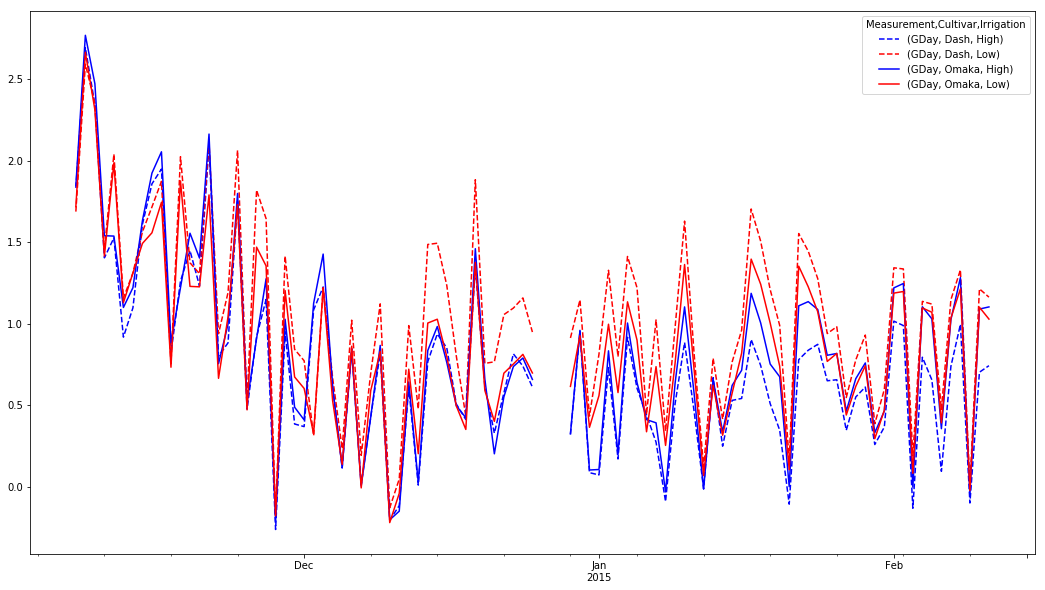

In [20]:
SoilHeatFluxMJMeans = SoilHeatFluxMJ.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
SoilHeatFluxMJDaylightMeans = SoilHeatFluxMJMeans.loc[DaylightIndex,:].resample('24h',base=6).sum()
SoilHeatFluxMJDaylightMeans.index = SoilHeatFluxMJDaylightMeans.index.normalize()
IncommingRadnDaylight = Data.IncomingRadnMJ.loc[DateIndex,:].loc[DaylightIndex,:].resample('24h',base=6).sum() 
IncommingRadnDaylight.index = IncommingRadnDaylight.index.normalize()

GDay = SoilHeatFluxMJDaylightMeans.values

tup = ['GDay']
Irrigs = ['High','Low']
reps = [1,2,3]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigs],names=['Measurement','Cultivar','Irrigation'])
GDayDF = pd.DataFrame(data = GDay, index = IncommingRadnDaylight.index, columns = NewIndex)
GDayDF.loc[pd.to_datetime(['2014-12-26 00:00:00',
                           '2014-12-27 00:00:00',
                           '2014-12-28 00:00:00',
                           '2015-02-12 00:00:00',
                           '2015-02-13 00:00:00',
                            '2015-02-14 00:00:00',
                            '2015-02-15 00:00:00',
                            '2015-02-16 00:00:00',
                            '2015-02-17 00:00:00',
                            '2015-02-18 00:00:00',
                            '2015-02-19 00:00:00',
                            '2015-02-20 00:00:00',
                            '2015-02-21 00:00:00',
                            '2015-02-22 00:00:00',
                            '2015-02-23 00:00:00',
                            '2015-02-24 00:00:00']),:] = np.nan
GDayDF.loc['2014-11-07':].plot(figsize=(18,10),style=['b--','r--','b-','r-'])
#GDayDF.loc['2014-12-1':'2014-12-7'].groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(figsize=(18,10),style=['b--','r--','b-','r-'])

### Bring in radiation interception data

In [21]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPARTot.pkl')
CoverDataMeans = CoverData.groupby(level=('Cultivar','Irrigation'),axis=1).mean()

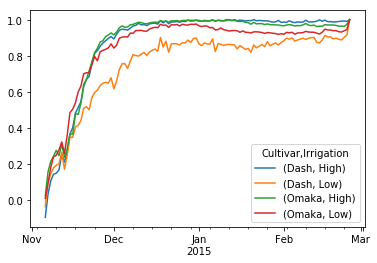

In [22]:
CoverDataMeans.plot()

## Make a data frame for comparing GRn with other variables

In [23]:
def SliceFullPlots(CompleteData,Variable):
    Chunk = CompleteData.loc[:,Variable]
    NewIndex = pd.MultiIndex.from_product([Cultivars,['Low','Mid','High'],[1,2,3,4]],names=['Cultivar','Irrigation',''])
    Chunk.columns = NewIndex
    SubIndex = pd.MultiIndex.from_product([Cultivars,['Low','High'],[1,3,4]],names=['Cultivar','Irrigation',''])
    SubChunk = Chunk.loc[DaylightIndex,SubIndex]
    SubChunkGroup = SubChunk.groupby(level=('Cultivar','Irrigation'), axis=1).mean()
    SubChunkAgregate = SubChunkGroup.resample('24h',base=6).mean()
    SubChunkAgregate.index = SubChunkAgregate.index.normalize()
    SubChunkUnstack = SubChunkAgregate.unstack()
    return SubChunkUnstack
    

In [24]:
LongG = GDayDF.loc[:,('GDay')].unstack(0)
LongData = pd.DataFrame(LongG, columns = ['GDay'])
for cul in Cultivars:
    for irr in IrrigationsShort:
        LongData.loc[(cul,irr),'AirTemperature'] = Data.loc[DaylightIndex,'AirTemperature'].resample('24h',base=6).mean().values
        LongData.loc[(cul,irr),'RelativeHumidity'] = Data.loc[DaylightIndex,'RelativeHumidity'].resample('24h',base=6).mean().values
        LongData.loc[(cul,irr),'Windspeed'] = Data.loc[DaylightIndex,'Windspeed'].resample('24h',base=6).mean().values
        LongData.loc[(cul,irr),'IncomingRadnMJ'] = Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('24h',base=6).sum().values

LongData.loc[:,'fPAR'] = CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().unstack()
LongData.loc[:,'SurfaceSoilTemp'] = SliceFullPlots(Data,'SurfaceSoilTemp')
LongData.loc[:,'TempAirSoil1Diff'] = LongData.loc[:,'AirTemperature'] - SliceFullPlots(Data,'SurfaceSoilTemp') 
SubIndex = pd.MultiIndex.from_product([['TopTemp'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopTempDF.loc[DaylightIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongData.loc[:,'SoilTemp15'] = Temp.unstack()
LongData.loc[:,'TempAirSoil15Diff'] = LongData.loc[:,'AirTemperature'] - LongData.loc[:,'SoilTemp15'] 
SubIndex = pd.MultiIndex.from_product([['TopWater'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopWaterDF.loc[DaylightIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongData.loc[:,'SoilWater'] = Temp.unstack()
LongData.loc[:,'SoilRad'] = LongData.loc[:,'IncomingRadnMJ']* (1-LongData.loc[:,'fPAR'])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [69]:
Data.loc[:,'IncomingRadnMJ'].loc['2014-12-1':'2014-12-7',:]


Cultivar                 Expt
Irrigation               Expt
2014-12-01 00:00:00  0.000121
2014-12-01 00:15:00  0.000121
2014-12-01 00:30:00  0.000121
2014-12-01 00:45:00  0.000121
2014-12-01 01:00:00  0.000121
2014-12-01 01:15:00  0.000121
2014-12-01 01:30:00  0.000121
2014-12-01 01:45:00  0.000101
2014-12-01 02:00:00  0.000081
2014-12-01 02:15:00  0.000121
2014-12-01 02:30:00  0.000121
2014-12-01 02:45:00  0.000121
2014-12-01 03:00:00  0.000121
2014-12-01 03:15:00  0.000121
2014-12-01 03:30:00  0.000101
2014-12-01 03:45:00  0.000121
2014-12-01 04:00:00  0.000121
2014-12-01 04:15:00  0.000182
2014-12-01 04:30:00  0.000344
2014-12-01 04:45:00  0.000931
2014-12-01 05:00:00  0.002954
2014-12-01 05:15:00  0.006678
2014-12-01 05:30:00  0.010280
2014-12-01 05:45:00  0.011393
2014-12-01 06:00:00  0.016352
2014-12-01 06:15:00  0.014449
2014-12-01 06:30:00  0.014267
2014-12-01 06:45:00  0.022684
2014-12-01 07:00:00  0.021247
2014-12-01 07:15:00  0.027781
...                       ...
2014-12-07 16:30:00  0.068632
2014-12-07 16:45:00  0.037824
2014-12-07 17:00:00  0.027778
2014-12-07 17:15:00  0.027071
2014-12-07 17:30:00  0.022200
2014-12-07 17:45:00  0.021999
2014-12-07 18:00:00  0.015145
2014-12-07 18:15:00  0.013832
2014-12-07 18:30:00  0.011850
2014-12-07 18:45:00  0.009524
2014-12-07 19:00:00  0.008068
2014-12-07 19:15:00  0.006855
2014-12-07 19:30:00  0.002892
2014-12-07 19:45:00  0.000789
2014-12-07 20:00:00  0.000344
2014-12-07 20:15:00  0.000101
2014-12-07 20:30:00  0.000020
2014-12-07 20:45:00  0.000000
2014-12-07 21:00:00  0.000000
2014-12-07 21:15:00  0.000000
2014-12-07 21:30:00  0.000000
2014-12-07 21:45:00  0.000000
2014-12-07 22:00:00  0.000000
2014-12-07 22:15:00  0.000000
2014-12-07 22:30:00  0.000000
2014-12-07 22:45:00  0.000000
2014-12-07 23:00:00  0.000000
2014-12-07 23:15:00  0.000000
2014-12-07 23:30:00  0.000000
2014-12-07 23:45:00  0.000000

[672 rows x 1 columns]

## Look at heat flux against different variables

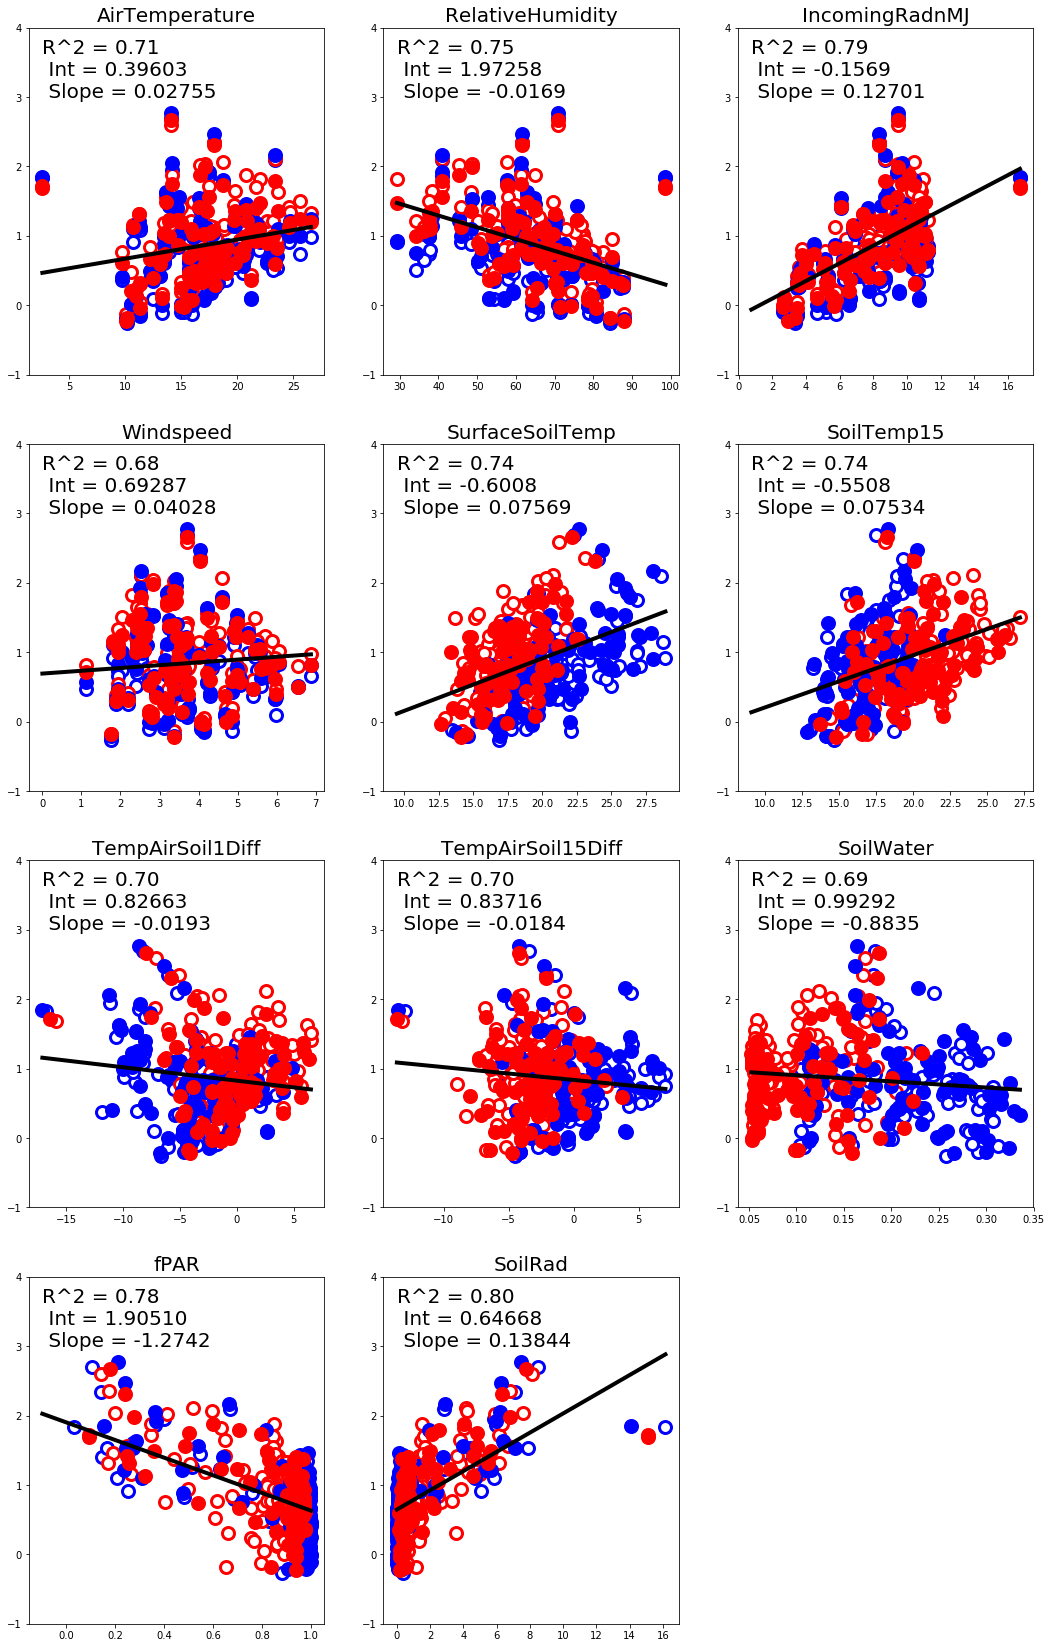

<Figure size 1296x720 with 0 Axes>

In [25]:
Graph = plt.figure(figsize=(18,60))
start = '2014-12-10'
end = '2015-02-10'
plt.figure(figsize=(18,10))
ecols = ['b','r','b','r']
fcols = ['w','w','b','r']
Irrigations = ['High','Low']
pannel = 1
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ',
               'Windspeed','SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR','SoilRad']
for des in Descriptors:
    DailyDescriptor = LongData.loc[:,des]
    fig = Graph.add_subplot(8,3,pannel)
    pos = 0
    for cul in Cultivars:
        for irr in Irrigations:
            fig.plot(LongData.loc[(cul,irr),des].loc['2014-11-07':],
                LongData.loc[(cul,irr),'GDay'].loc['2014-11-07':],
                     'o',mec=ecols[pos],mfc=fcols[pos],mew = 3, markersize = 12,)
            pos+=1  
    
    X = LongData.loc[:,LongData.columns.isin([des])]
    Y = LongData.loc[:,'GDay']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
    fig.text(X.min(),3,fitR2,fontsize=20)
    fig.set_ylim(-1,4)
    fig.set_title(des, fontsize = 20)
    pannel +=1

## The best descriprors are fPAR, AirTemp and Humidity

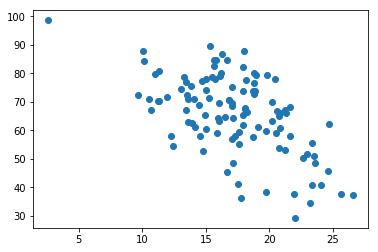

In [26]:
plt.plot(LongData.loc[(cul,irr),'AirTemperature'],
        LongData.loc[(cul,irr),'RelativeHumidity'],'o')

In [27]:
X = LongData.loc[(cul,irr),'AirTemperature']
Y = LongData.loc[(cul,irr),'RelativeHumidity']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeHumidity   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1906.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):           5.86e-85
Time:                        07:47:37   Log-Likelihood:                -421.41
No. Observations:                 110   AIC:                             846.8
Df Residuals:                     108   BIC:                             852.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             99.7305      4.757     20.965      0.000      90.301     109.160
AirTemperature    -1.9676      0.269     -7.319      0.000      -2.500      -1.435
==============================================================================
Omnibus:                        1.734   Durbin-Watson:                   0.769
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                1.791
Skew:                          -0.275   Prob(JB):                        0.408
Kurtosis:                       2.702   Cond. No.                         78.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Air temperature and relative humidity are highly correlated so lets forget about humidity as air temperature is easier to deal with in a practical situation

## How much of the variation can AirTemp and fPAR account for on their own.

In [28]:
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ','Windspeed',
              'SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR','SoilRad']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     497.8
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          3.09e-206
Time:                        07:47:37   Log-Likelihood:                -43.533
No. Observations:                 376   AIC:                             107.1
Df Residuals:                     366   BIC:                             146.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6518      0.291      2.240      0.026       0.080       1.224
AirTemperature        0.0283      0.003     10.983      0.000       0.023       0.033
RelativeHumidity      0.0013      0.002      0.847      0.397      -0.002       0.004
Windspeed            -0.0314      0.014     -2.267      0.024      -0.059      -0.004
IncomingRadnMJ        0.0967      0.009     10.852      0.000       0.079       0.114
fPAR                 -1.7836      0.206     -8.653      0.000      -2.189      -1.378
SurfaceSoilTemp       0.0125      0.003      3.869      0.000       0.006       0.019
TempAirSoil1Diff      0.0157      0.003      5.135      0.000       0.010       0.022
SoilTemp15            0.0150      0.006      2.438      0.015       0.003       0.027
TempAirSoil15Diff     0.0133      0.006      2.345      0.020       0.002       0.024
SoilWater             0.0261      0.321      0.081      0.935      -0.606       0.658
SoilRad              -0.0049      0.023     -0.216      0.829      -0.049       0.040
==============================================================================
Omnibus:                        5.415   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                6.215
Skew:                           0.157   Prob(JB):                       0.0447
Kurtosis:                       3.546   Cond. No.                     1.48e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.32e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
Descriptors = ['AirTemperature',
               'IncomingRadnMJ',
               'fPAR']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1243.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          9.44e-214
Time:                        07:47:37   Log-Likelihood:                -46.578
No. Observations:                 376   AIC:                             101.2
Df Residuals:                     372   BIC:                             116.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6415      0.081      7.876      0.000       0.481       0.802
AirTemperature     0.0559      0.004     14.610      0.000       0.048       0.063
IncomingRadnMJ     0.0889      0.006     15.701      0.000       0.078       0.100
fPAR              -1.7427      0.067    -25.925      0.000      -1.875      -1.610
==============================================================================
Omnibus:                        3.472   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.462
Skew:                           0.139   Prob(JB):                        0.177
Kurtosis:                       3.379   Cond. No.                         126.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
Descriptors = ['AirTemperature',
               'SoilRad']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1134.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          4.68e-187
Time:                        07:47:37   Log-Likelihood:                -112.38
No. Observations:                 376   AIC:                             230.8
Df Residuals:                     373   BIC:                             242.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7032      0.084     -8.415      0.000      -0.868      -0.539
AirTemperature     0.0737      0.004     16.456      0.000       0.065       0.083
SoilRad            0.2086      0.008     26.802      0.000       0.193       0.224
==============================================================================
Omnibus:                        2.356   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                2.089
Skew:                           0.156   Prob(JB):                        0.352
Kurtosis:                       3.190   Cond. No.                         87.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## R^2 of 0.93 with Radiation and fPAR and AirTemp and 0.931 with all others included.  No need to include the others!!!

In [31]:
# def estGDay(Radn, fPAR, AirTemp):
#     Const = 0.6306 
#     RadEff = np.multiply(Radn.values,0.0906)
#     fPAREff = np.multiply(fPAR, -1.733)
#     AirTempEff = np.multiply(AirTemp.values,0.0556)
#     return Const + RadEff + fPAREff + AirTempEff 
def estGDay(SoilRadn, AirTemp):
    Const = -0.7091
    SoilRadEff = np.multiply(SoilRadn.values,0.2149)
    AirTempEff = np.multiply(AirTemp.values,0.0736)
    return Const + SoilRadEff  + AirTempEff 

In [32]:
LongData.loc[:,'EstGDayMJ'] = estGDay(LongData.loc[:,'SoilRad'],
                                     LongData.loc[:,'AirTemperature'])

Text(0.039056,2,'R^2 = 0.90\n Int = 0.02006\n Slope = 0.97506')

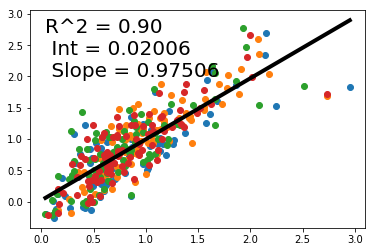

In [33]:
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        plt.plot(Pred,Obs,'o')

X = LongData.loc[:,'EstGDayMJ']
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),2.,fitR2,fontsize=20)        


## Day time Soil heat flux can be modeled as 
GDay = 0.6306 + IncommingRadn * 0.0906 + fPAR * -1.733 + AirT * 0.0556

## Now we can estimate day time soil heat flux for all plots

In [34]:
DailyFPAR = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')

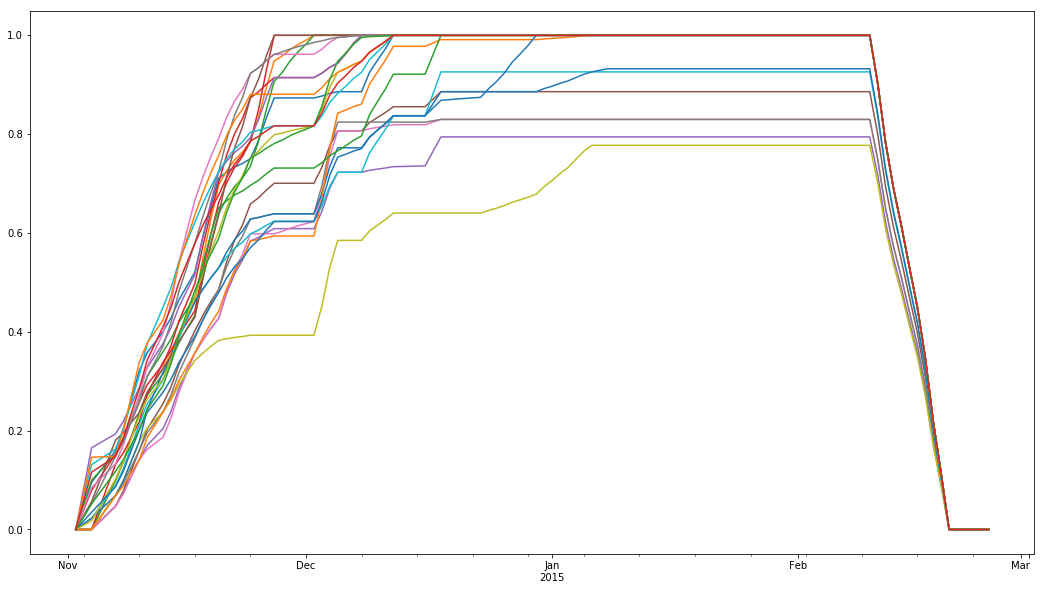

In [35]:
DailyFPAR.plot(legend=False,figsize=(18,10))

In [36]:
DayGEst = pd.DataFrame(index = DailyFPAR.index, columns = DailyFPAR.columns)
Radn = Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('24h',base=6).sum()
Radn.index = Radn.index.normalize()
Temp = Data.loc[DaylightIndex, 'AirTemperature'].resample('24h', base=6).mean()
Temp.index = Temp.index.normalize()
for plot in DayGEst:
    DayGEst.loc[:,plot] = estGDay((1-DailyFPAR.loc[:,plot]) * Radn.loc[DailyFPAR.index,('Expt','Expt')],
                                 Temp.loc[DailyFPAR.index,('Expt','Expt')])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [37]:
DayGEst.index.name='Date'

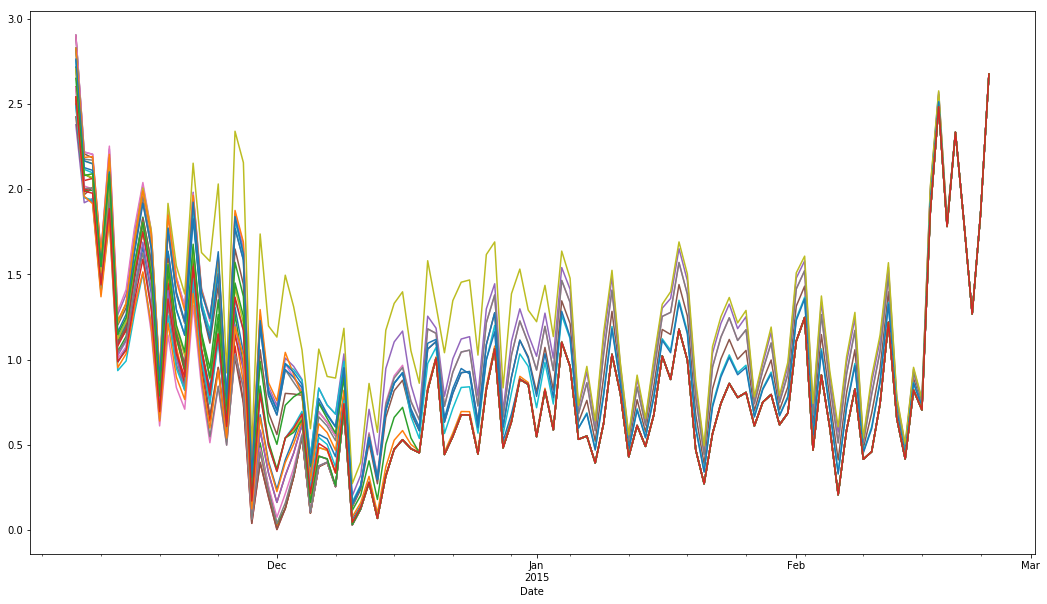

In [38]:
DayGEst.plot(figsize=(18,10), legend = False)

In [39]:
DayGEst.to_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')

## Have a look at Dark heat flux

In [40]:
DarkIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ<0.002)
DarkIndex.dropna(inplace=True)
DarkIndex = DarkIndex.index.tolist()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


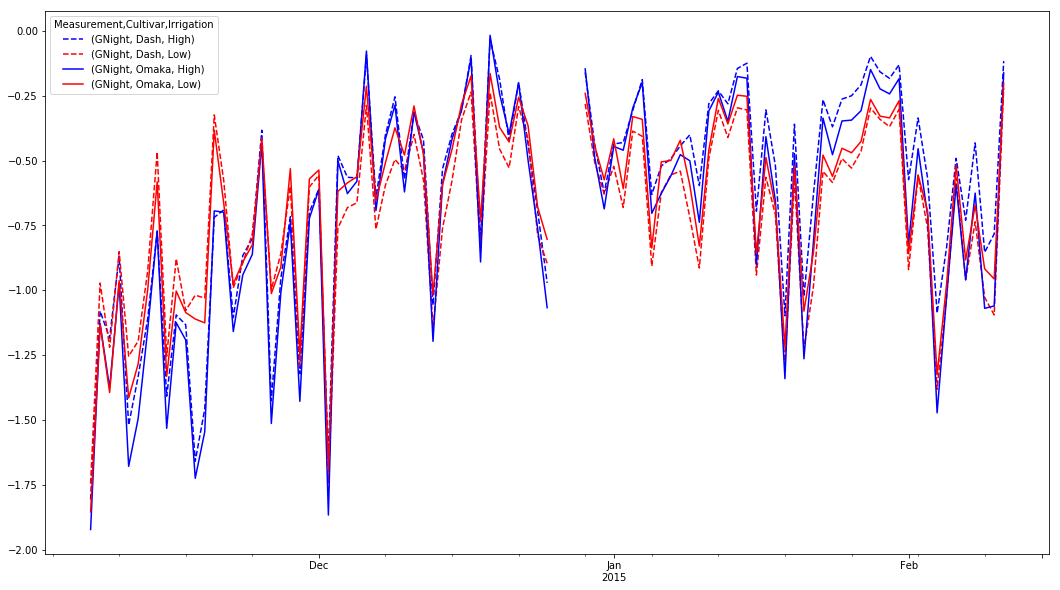

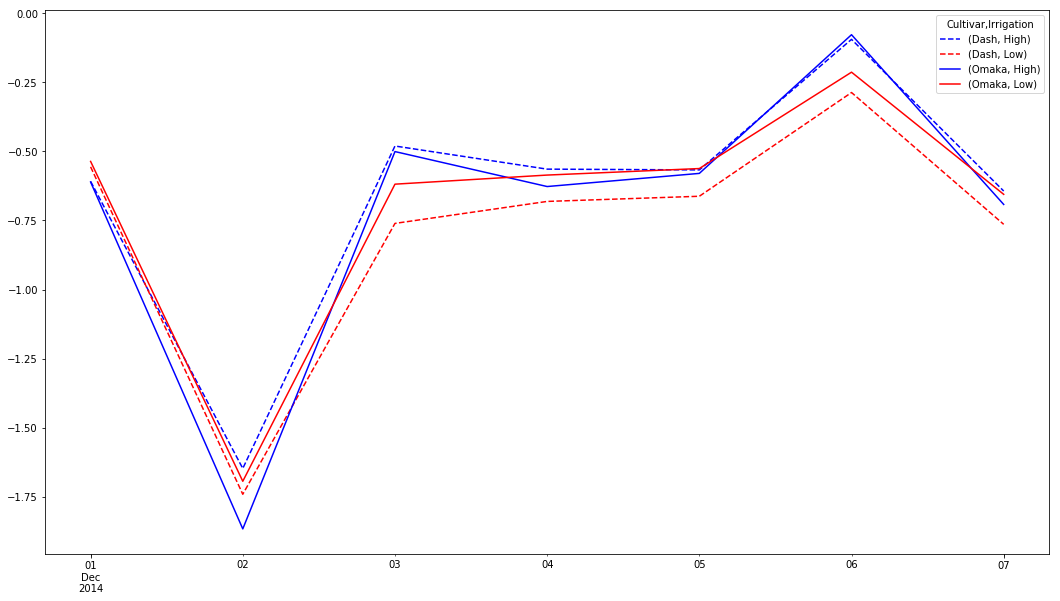

In [41]:
SoilHeatFluxMJNightMeans = SoilHeatFluxMJMeans.loc[DarkIndex,:].resample('24h',base=6).sum()
SoilHeatFluxMJNightMeans.index = SoilHeatFluxMJNightMeans.index.normalize()

GNight = SoilHeatFluxMJNightMeans.values

tup = ['GNight']
reps = [1,2,3]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigs],names=['Measurement','Cultivar','Irrigation'])
GNightDF = pd.DataFrame(data = GNight, index = IncommingRadnDaylight.index, columns = NewIndex)
GNightDF.loc[pd.to_datetime(['2014-12-26 00:00:00',
                           '2014-12-27 00:00:00',
                           '2014-12-28 00:00:00',
                           '2015-02-12 00:00:00',
                           '2015-02-13 00:00:00',
                            '2015-02-14 00:00:00',
                            '2015-02-15 00:00:00',
                            '2015-02-16 00:00:00',
                            '2015-02-17 00:00:00',
                            '2015-02-18 00:00:00',
                            '2015-02-19 00:00:00',
                            '2015-02-20 00:00:00',
                            '2015-02-21 00:00:00',
                            '2015-02-22 00:00:00',
                            '2015-02-23 00:00:00',
                            '2015-02-24 00:00:00']),:] = np.nan
GNightDF.loc['2014-11-07':].plot(figsize=(18,10),style=['b--','r--','b-','r-'],)
GNightDF.loc['2014-12-1':'2014-12-7'].groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(figsize=(18,10),style=['b--','r--','b-','r-'])

In [42]:
def SliceFullPlotsDark(CompleteData,Variable):
    Chunk = CompleteData.loc[:,Variable]
    NewIndex = pd.MultiIndex.from_product([Cultivars,['Low','Mid','High'],[1,2,3,4]],names=['Cultivar','Irrigation',''])
    Chunk.columns = NewIndex
    SubIndex = pd.MultiIndex.from_product([Cultivars,['Low','High'],[1,3,4]],names=['Cultivar','Irrigation',''])
    SubChunk = Chunk.loc[DarkIndex,SubIndex]
    SubChunkGroup = SubChunk.groupby(level=('Cultivar','Irrigation'), axis=1).mean()
    SubChunkAgregate = SubChunkGroup.resample('24h',base=6).mean()
    SubChunkAgregate.index = SubChunkAgregate.index.normalize()
    SubChunkUnstack = SubChunkAgregate.unstack()
    return SubChunkUnstack
    

In [43]:
LongG = GNightDF.loc[:,('GNight')].unstack(0)
LongDataDark = pd.DataFrame(LongG, columns = ['GDark'])
for cul in Cultivars:
    for irr in IrrigationsShort:
        LongDataDark.loc[(cul,irr),'AirTemperature'] = Data.loc[DarkIndex,'AirTemperature'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'RelativeHumidity'] = Data.loc[DarkIndex,'RelativeHumidity'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'Windspeed'] = Data.loc[DarkIndex,'Windspeed'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'IncomingRadnMJ'] = Data.loc[DarkIndex,'IncomingRadnMJ'].resample('24h',base=6).sum().values

LongDataDark.loc[:,'fPAR'] = CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().unstack()
LongDataDark.loc[:,'SurfaceSoilTemp'] = SliceFullPlots(Data,'SurfaceSoilTemp')
LongDataDark.loc[:,'TempAirSoil1Diff'] = LongDataDark.loc[:,'AirTemperature'] - SliceFullPlots(Data,'SurfaceSoilTemp') 
SubIndex = pd.MultiIndex.from_product([['TopTemp'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopTempDF.loc[DarkIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongDataDark.loc[:,'SoilTemp15'] = Temp.unstack()
LongDataDark.loc[:,'TempAirSoil15Diff'] = LongDataDark.loc[:,'AirTemperature'] - LongDataDark.loc[:,'SoilTemp15'] 
SubIndex = pd.MultiIndex.from_product([['TopWater'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopWaterDF.loc[DarkIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongDataDark.loc[:,'SoilWater'] = Temp.unstack()


C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


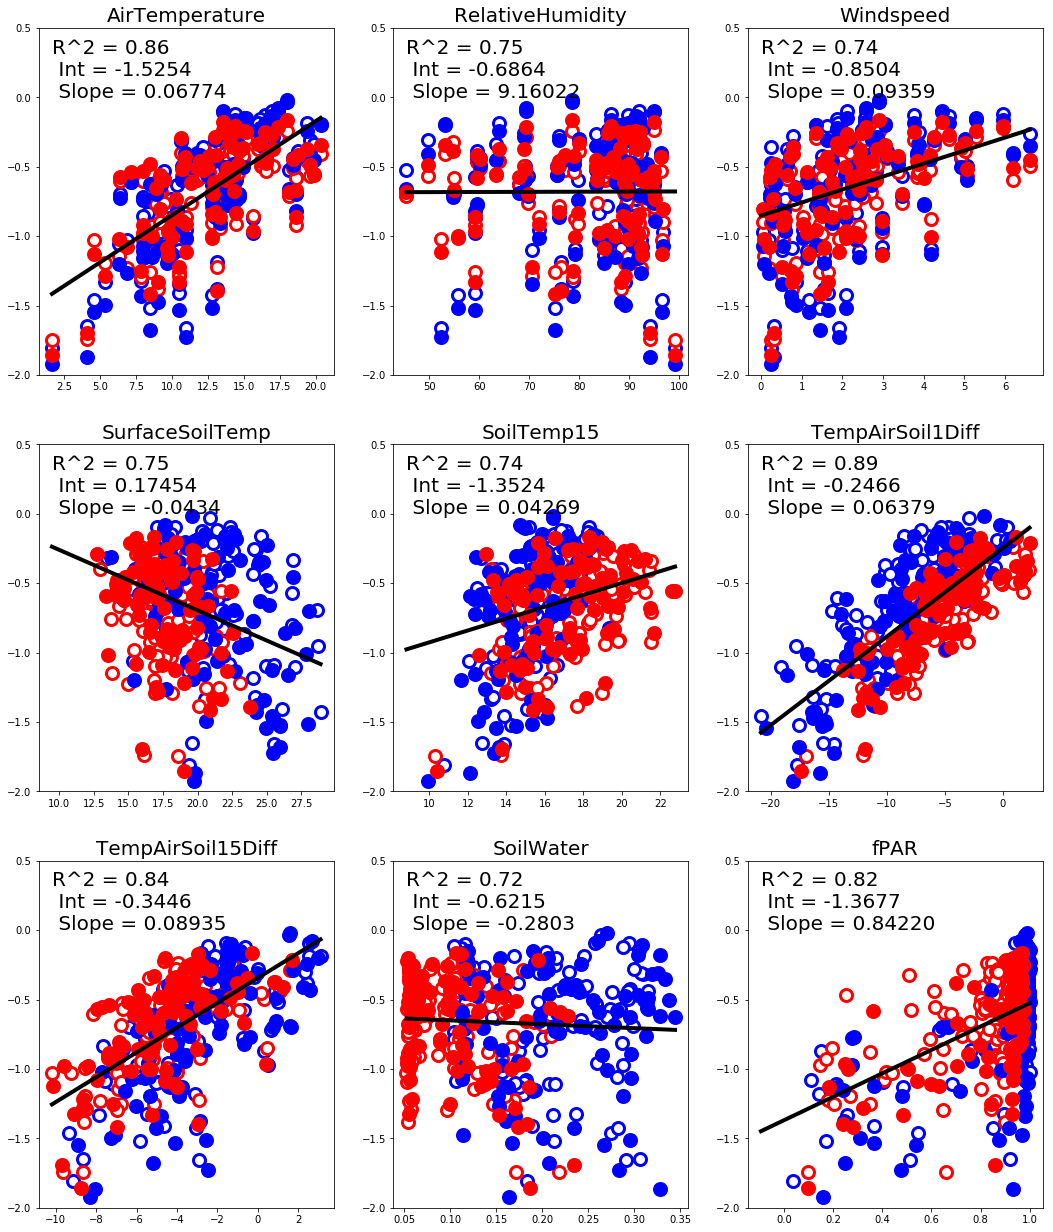

<Figure size 1296x720 with 0 Axes>

In [44]:
Graph = plt.figure(figsize=(18,60))
start = '2014-12-10'
end = '2015-02-10'
plt.figure(figsize=(18,10))
ecols = ['b','r','b','r']
fcols = ['w','w','b','r']
Irrigations = ['High','Low']
pannel = 1
Descriptors = ['AirTemperature','RelativeHumidity',
               'Windspeed','SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR']
for des in Descriptors:
    DailyDescriptor = LongDataDark.loc[:,des]
    fig = Graph.add_subplot(8,3,pannel)
    pos = 0
    for cul in Cultivars:
        for irr in Irrigations:
            fig.plot(LongDataDark.loc[(cul,irr),des].loc['2014-11-07':],
                LongDataDark.loc[(cul,irr),'GDark'].loc['2014-11-07':],
                     'o',mec=ecols[pos],mfc=fcols[pos],mew = 3, markersize = 12,)
            pos+=1  
    
    X = LongDataDark.loc[:,LongDataDark.columns.isin([des])]
    Y = LongDataDark.loc[:,'GDark']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
    fig.text(X.min(),-0,fitR2,fontsize=20)
    fig.set_ylim(-2,0.5)
    fig.set_title(des, fontsize = 20)
    pannel +=1

Text(-0.26178,2,'R^2 = 0.76\n Int = -0.3909\n Slope = -0.3113')

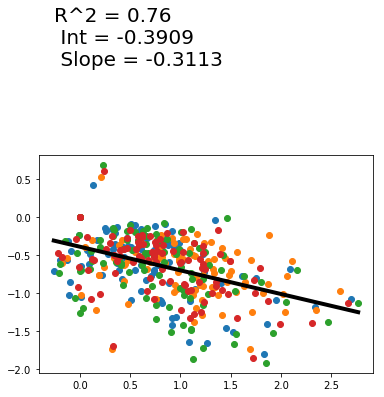

In [45]:
for cul in Cultivars:
    for irr in Irrigations:
        Day = LongData.loc[(cul,irr),'GDay']
        Night = LongDataDark.loc[(cul,irr),'GDark']
        plt.plot(Day,Night,'o')

X = LongData.loc[:,'GDay']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),2.,fitR2,fontsize=20)        


In [46]:
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ','Windspeed',
              'SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR']
X = LongDataDark.loc[:,LongDataDark.columns.isin(Descriptors)]
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GDark   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     892.2
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          2.24e-243
Time:                        07:47:41   Log-Likelihood:                 146.95
No. Observations:                 376   AIC:                            -275.9
Df Residuals:                     367   BIC:                            -240.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.5728      0.135    -11.657      0.000      -1.838      -1.307
AirTemperature        0.0281      0.002     16.538      0.000       0.025       0.031
RelativeHumidity      0.0098      0.001     10.352      0.000       0.008       0.012
Windspeed             0.0448      0.007      6.569      0.000       0.031       0.058
IncomingRadnMJ        6.9343      3.042      2.280      0.023       0.953      12.915
fPAR                  0.4547      0.045     10.193      0.000       0.367       0.542
SurfaceSoilTemp       0.0016      0.002      0.868      0.386      -0.002       0.005
TempAirSoil1Diff      0.0265      0.002     17.136      0.000       0.023       0.030
SoilTemp15           -0.0209      0.004     -4.670      0.000      -0.030      -0.012
TempAirSoil15Diff     0.0491      0.004     11.287      0.000       0.041       0.058
SoilWater            -0.6272      0.171     -3.675      0.000      -0.963      -0.292
==============================================================================
Omnibus:                        2.246   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                2.204
Skew:                          -0.056   Prob(JB):                        0.332
Kurtosis:                       3.358   Cond. No.                     3.19e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.84e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [47]:
Descriptors = ['AirTemperature','fPAR']
X = LongDataDark.loc[:,LongDataDark.columns.isin(Descriptors)]
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GDark   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1123.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          2.44e-186
Time:                        07:47:41   Log-Likelihood:                -8.0005
No. Observations:                 376   AIC:                             22.00
Df Residuals:                     373   BIC:                             33.79
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.9147      0.055    -34.983      0.000      -2.022      -1.807
AirTemperature     0.0544      0.003     15.568      0.000       0.048       0.061
fPAR               0.6719      0.058     11.560      0.000       0.558       0.786
==============================================================================
Omnibus:                       27.125   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.992
Skew:                          -0.659   Prob(JB):                     1.86e-07
Kurtosis:                       3.490   Cond. No.                         73.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
def EstGDarkMJ(AirTemp,FPAR):
    Constant = -1.9157
    AirTempEff = np.multiply(AirTemp.values,0.0545)
    FPAREff = np.multiply(FPAR.values,0.666)  # 0.1% of the number of the beast   
    return Constant + AirTempEff + FPAREff

In [49]:
LongDataDark.loc[:,'EstGDarkMJ'] = EstGDarkMJ(LongDataDark.loc[:,'AirTemperature'],
                                  LongDataDark.loc[:,'fPAR'])

Text(-2.00425,-0.7,'R^2 = 0.90\nInt = 0.00603\nSlope = 1.00221')

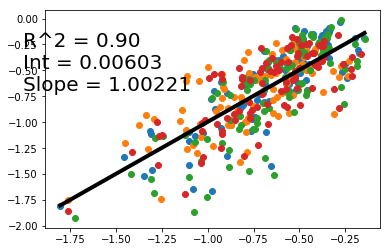

In [50]:
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        plt.plot(Pred,Obs,'o')

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\nInt = ' + str(Regres.params[0])[:7] + '\nSlope = ' + str(Regres.params[1])[:7]
plt.text(X.min()-.2,-0.7,fitR2,fontsize=20)        


## Night time soil heat flux can be estimated by
 -1.9157 + AirT * 0.0545 + fPAR * 0.666
## So we can get an estimate of GNight for each plot

In [51]:
NightGEst = pd.DataFrame(index = DailyFPAR.index, columns = DailyFPAR.columns)
Temp = Data.loc[DaylightIndex, 'AirTemperature'].resample('24h', base=6).mean()
Temp.index = Temp.index.normalize()
for plot in NightGEst:
    NightGEst.loc[:,plot] = EstGDarkMJ(Temp.loc[DailyFPAR.index,('Expt','Expt')],
                                     DailyFPAR.loc[:,plot])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


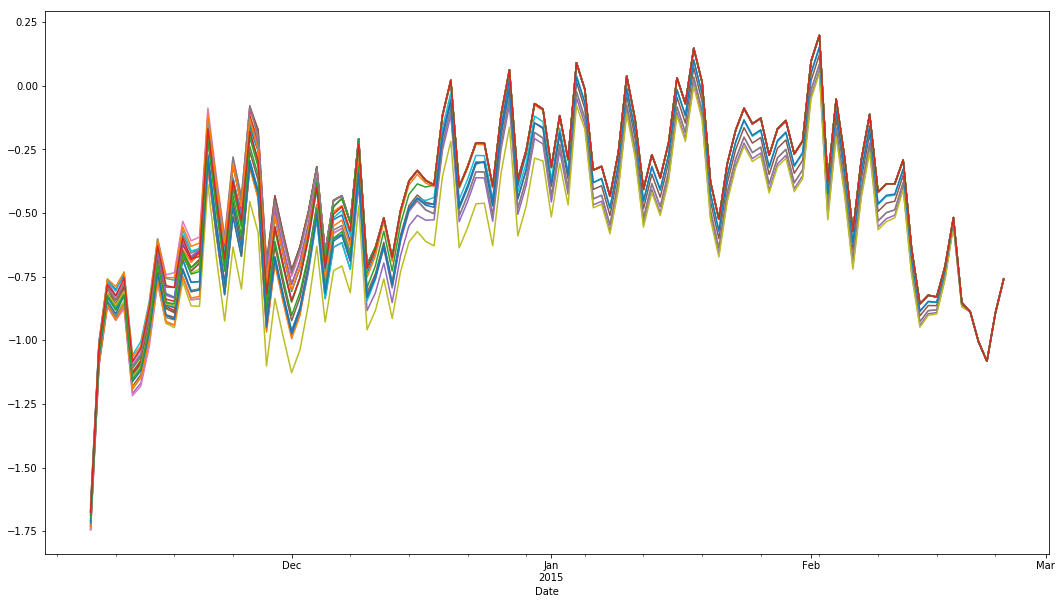

In [52]:
NightGEst.plot(figsize=(18,10),legend=False)

In [53]:
NightGEst.to_pickle('.\DataFrames\SoilHeatfluxNightEst.pkl')

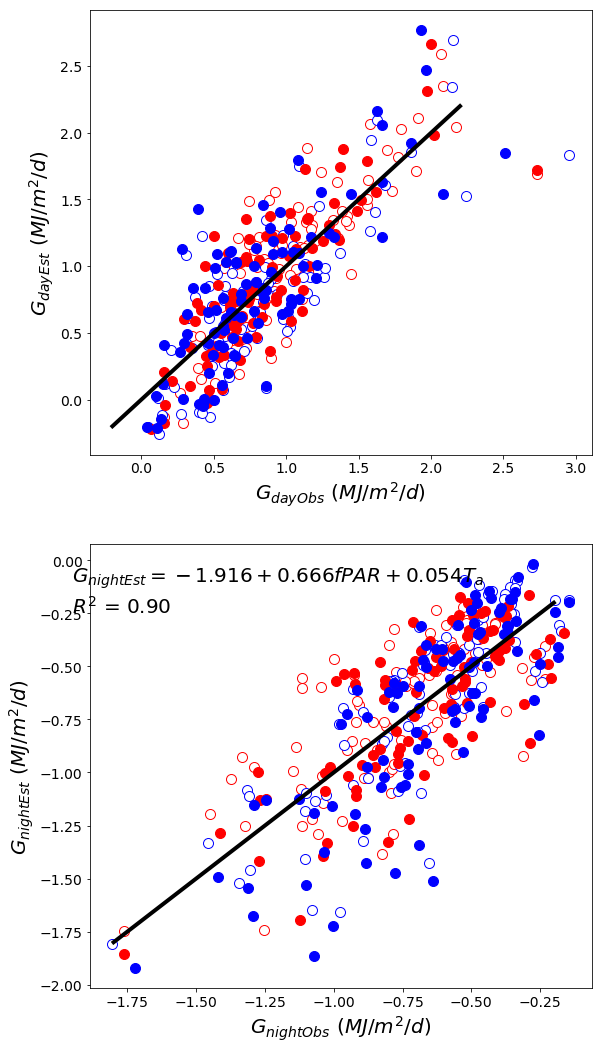

In [54]:
Graph = plt.figure(figsize=(9,18))

Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
alphas = [0.2,0.3]

fig = Graph.add_subplot(2,1,2)
Pos =0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Xs = [-1.8,-0.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)
plt.ylabel('$G_{nightEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{nightObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.90'
plt.text(-1.95,-0.25,fitR2,fontsize=20)  
model = '$G_{nightEst} = -1.916 + 0.666 fPAR + 0.054 T_a$'
plt.text(-1.95, -0.1,model,fontsize=20)

fig = Graph.add_subplot(2,1,1)
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
        
Xs = [-.2,2.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)   
plt.ylabel('$G_{dayEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{dayObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.93' 
#plt.text(-0.4,2.5,fitR2,fontsize=20) 
model = '$G_{dayEst} = 0.71 + 0.21R_s(1-fPAR) + 0.073 T_a$'
#plt.text(-0.4, 2.8,model,fontsize=20)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


Text(-0.4,2.7,'(d)')

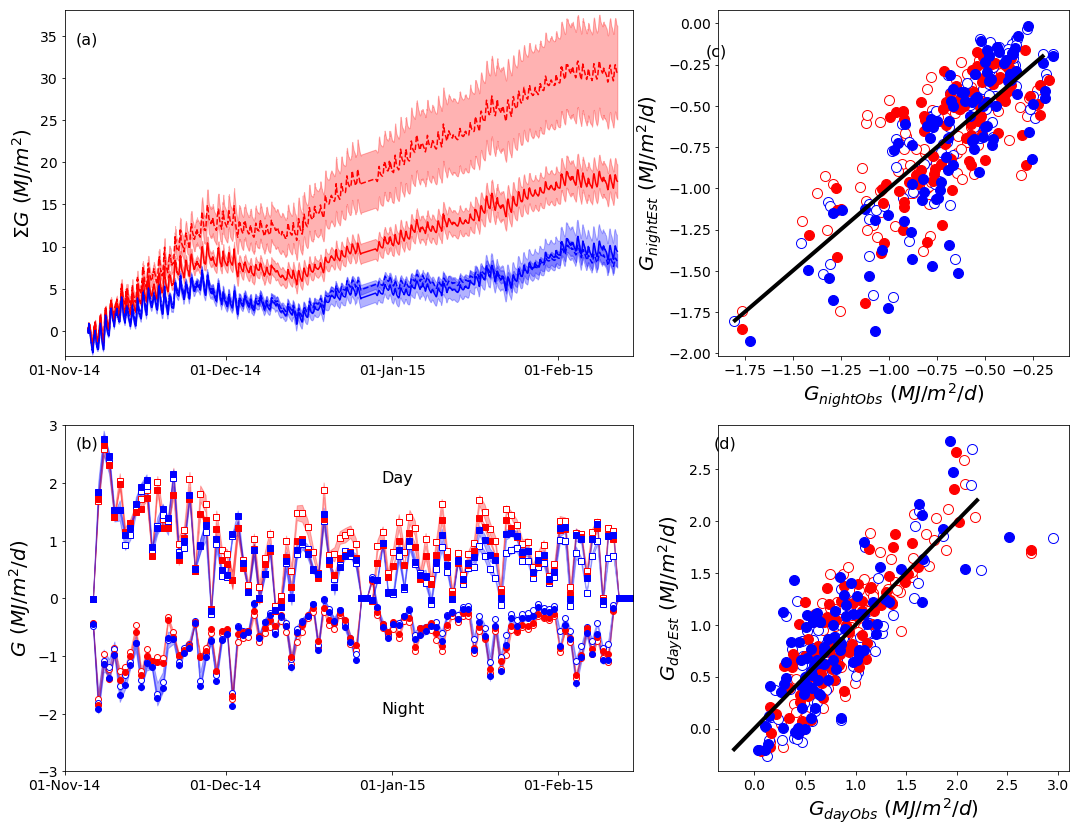

In [55]:
Graph = plt.figure(figsize=(18,14))
Shape = (2,14)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
alphas = [0.2,0.3]

fig = plt.subplot2grid(Shape,(0,0),colspan=8)#Graph.add_subplot(2,1,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.index
        Med = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,cultLines[CulPos],color=irrigColors[IrrPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.xlim('2014-11-1','2015-02-15')
plt.ylim(-3,38)
plt.ylabel('$\Sigma G$ $(MJ/m^2)$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-11-3',34,'(a)',fontsize=16)

fig = plt.subplot2grid(Shape,(1,0),colspan=8)#Graph.add_subplot(2,1,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1

CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'s',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(-3,3)
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$G$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-11-3',2.6,'(b)',fontsize=16)
plt.text('2014-12-30', 2,'Day',fontsize=16)
plt.text('2014-12-30', -2,'Night',fontsize=16)

fig = plt.subplot2grid(Shape,(0,9),colspan=5)#Graph.add_subplot(2,1,2)
Pos =0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Xs = [-1.8,-0.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)
plt.ylabel('$G_{nightEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{nightObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.90'
#plt.text(-1.95,-0.25,fitR2,fontsize=20)  
model = '$G_{nightEst} = -1.916 + 0.666 fPAR + 0.054 T_a$'
#plt.text(-1.95, -0.1,model,fontsize=20)
plt.text(-1.95,-.2,'(c)',fontsize=16)

fig = plt.subplot2grid(Shape,(1,9),colspan=5)#Graph.add_subplot(2,1,1)
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
        
Xs = [-.2,2.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)   
plt.ylabel('$G_{dayEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{dayObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.93' 
#plt.text(-0.4,2.5,fitR2,fontsize=20) 
model = '$G_{dayEst} = 0.631 + 0.091 R - 1.734 fPAR + 0.056 T_a$'
#plt.text(-0.4, 2.8,model,fontsize=20)
plt.text(-0.4,2.7,'(d)',fontsize=16)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


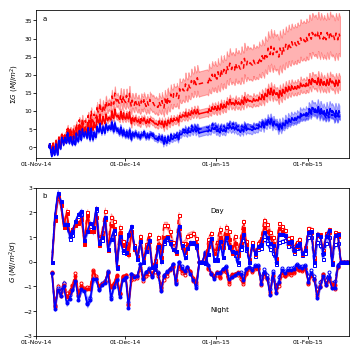

In [56]:
Graph = plt.figure(figsize=(5.6,6))
Shape = (2,14)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
gaps = [3,3,0.0001,0.0001]
alphas = [0.2,0.3]

fig = Graph.add_subplot(2,1,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.index
        Med = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,cultLines[CulPos],color=irrigColors[IrrPos],label = Cul + ' ' + Irr,dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1
plt.xlim('2014-11-1','2015-02-15')
plt.ylim(-3,38)
plt.ylabel('$\Sigma G$ $(MJ/m^2)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=6)    
plt.text('2014-11-3',35,'a',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
       
fig = Graph.add_subplot(2,1,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,markersize=3,color = irrigColors[IrrPos],dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1

CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'s',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,markersize=3,color = irrigColors[IrrPos],dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1
plt.ylim(-3,3)
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$G$ $(MJ/m^2/d)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=6)    
plt.text('2014-11-3',2.6,'b',fontsize=7)
plt.text('2014-12-30', 2,'Day',fontsize=7)
plt.text('2014-12-30', -2,'Night',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
       
Graph.savefig('Fig_4.jpg',dpi=1000)

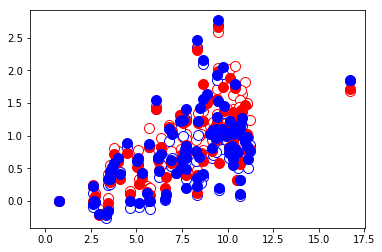

In [57]:
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'IncomingRadnMJ']
        plt.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
plt.plot([0,])